In [18]:
from tensorflow.keras.models import load_model

from generators import Singlet

In [20]:
#base_model_history = pickle.load(open(C.base_model+"_history", "rb"))
from create_base_model import model_path
trained_model = load_model(model_path("trained_"+C.base_model))
datagen = Singlet(batch_size=1, directory=C.val_dir, steps_per_epoch=1000)

ValueError: axes don't match array

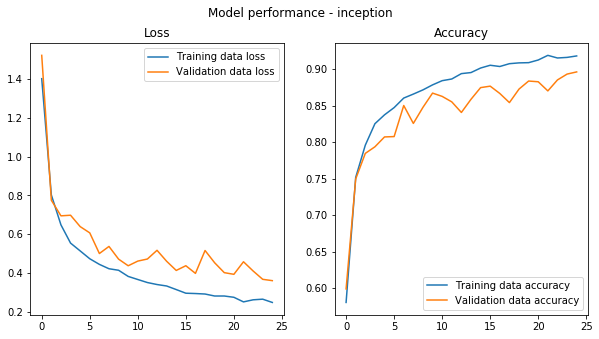

In [16]:
import pandas as pd
df = pd.read_csv("history_trained_"+C.base_model)

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training data loss')
    plt.plot(history['val_loss'], label='Validation data loss')
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history['acc'], label='Training data accuracy')
    plt.plot(history['val_acc'], label='Validation data accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.suptitle("Model performance - {}".format(C.base_model))
    plt.show()
plot_history(df)

In [ ]:
def plot_confusion_matrix(model, val_generator):
    img_vals = []
    stat_vals = []
    y_vals = []
    for i in range(C.base_validation_steps):
        x, y = val_generator[i]
        if len(x) == 2:
            img_vals.append(x[0])
            stat_vals.append(x[1])
        else:
            img_vals.append(x)
        y_vals.append(y)
    if stat_vals:
        X_validation = [np.concatenate(img_vals), np.concatenate(stat_vals)]
    else:
        X_validation = [np.concatenate(img_vals)]
    y_target = np.concatenate(y_vals)
    y_predicted = np.argmax(model.predict(X_validation), axis=1)
    cm = confusion_matrix(y_target, y_predicted)
    for i in range(len(cm)):
        cm[i, i] = 0

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, cmap="Greys")
    plt.xticks(range(max(y_target+1)))
    plt.yticks(range(max(y_target+1)))
    plt.title("Confusion matrix")
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.savefig(os.path.join(outputfolder, 'model_confusion_matrix.png'))
    plt.show()

plot_confusion_matrix(trained_model, datagen)

In [37]:
from create_siamese_model import initialize_bitvector_model, model_path
from tensorflow.keras.models import load_model

from generators import Singlet
import config as C

import numpy as np

In [38]:
#bitvector_model = initialize_bitvector_model()
bitvector_model = load_model(model_path("hierachy_bitvector2_"+C.base_model))
#bitvector_model = load_model(model_path("bitvector_"+C.base_model))

Instructions for updating:
Colocations handled automatically by placer.


In [39]:
#import pandas as pd
#import matplotlib.pyplot as plt
#df = pd.read_csv("history_siamese_"+C.base_model)
#plt.figure(figsize=(10, 5))
#plt.plot(df['loss'], label='Training data loss')
#plt.plot(df['val_loss'], label='Validation data loss')
#plt.legend()
#plt.title("Loss")

In [40]:
nrSamples = 1000
datagen = Singlet(batch_size=1, directory=C.val_dir, steps_per_epoch=nrSamples)
imgs = []
labels = []
embeddings = []
for i in range(nrSamples):
    X, y = datagen[i]
    imgs.append(X)
    labels.append(y)
    embeddings.append(bitvector_model.predict_on_batch(X))
    
X = np.stack(embeddings).reshape((nrSamples, C.out_dim))
y = np.asarray(labels).reshape((nrSamples,))

X.shape, y.shape

((1000, 64), (1000,))

In [41]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, n_iter=3000)

In [42]:
X_2d = tsne.fit_transform(X)


In [43]:
import numpy as np
np.save('hb2_X_2d.npy', X_2d)
np.save('hb2_y.npy', y)

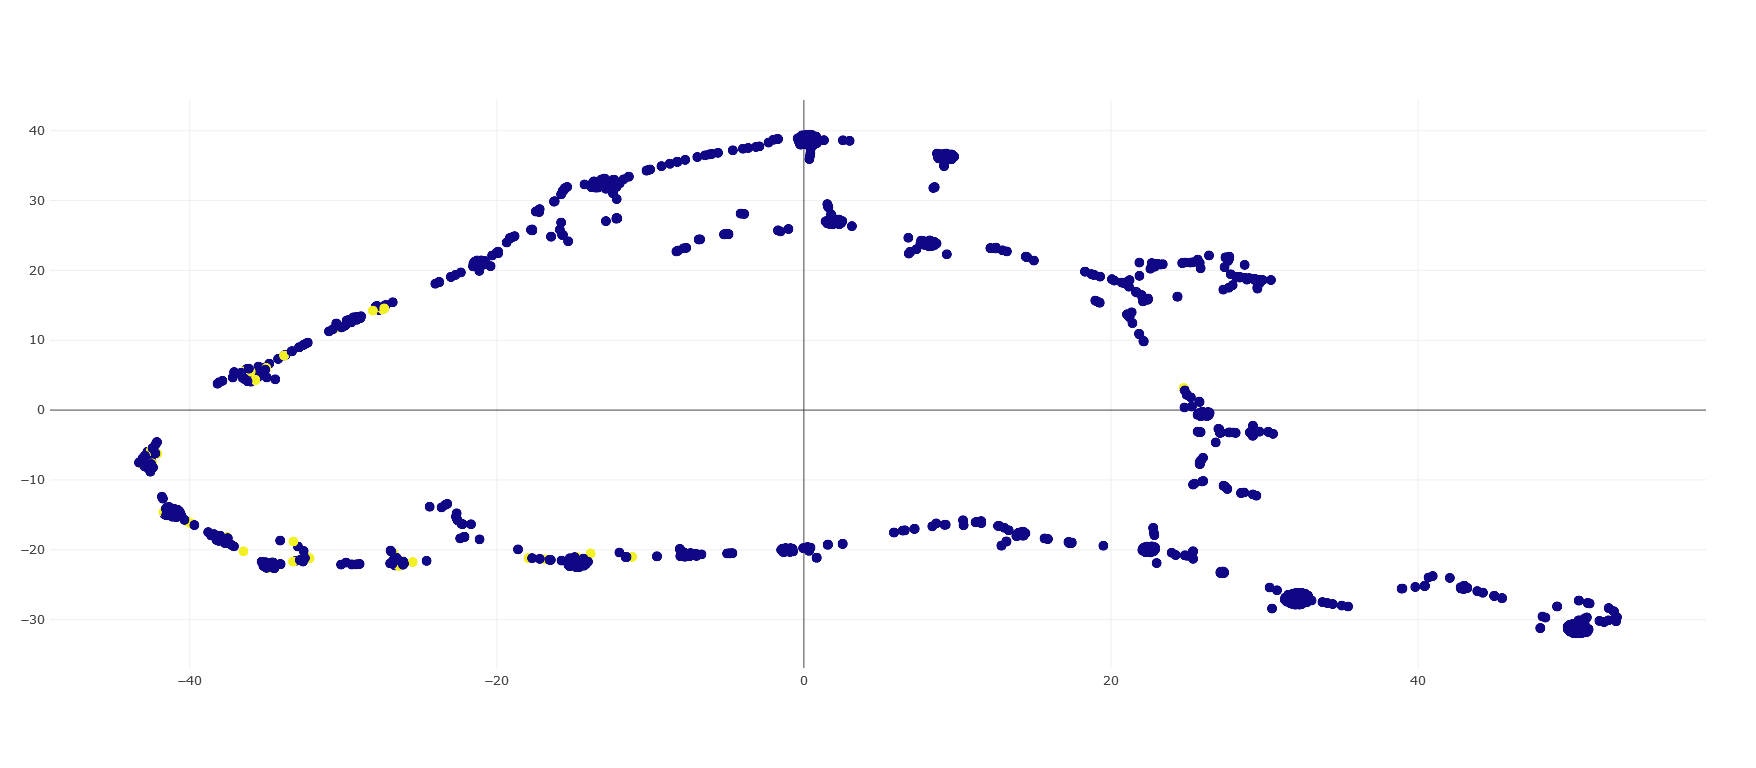

In [44]:
pyo.iplot(make_plot(1))

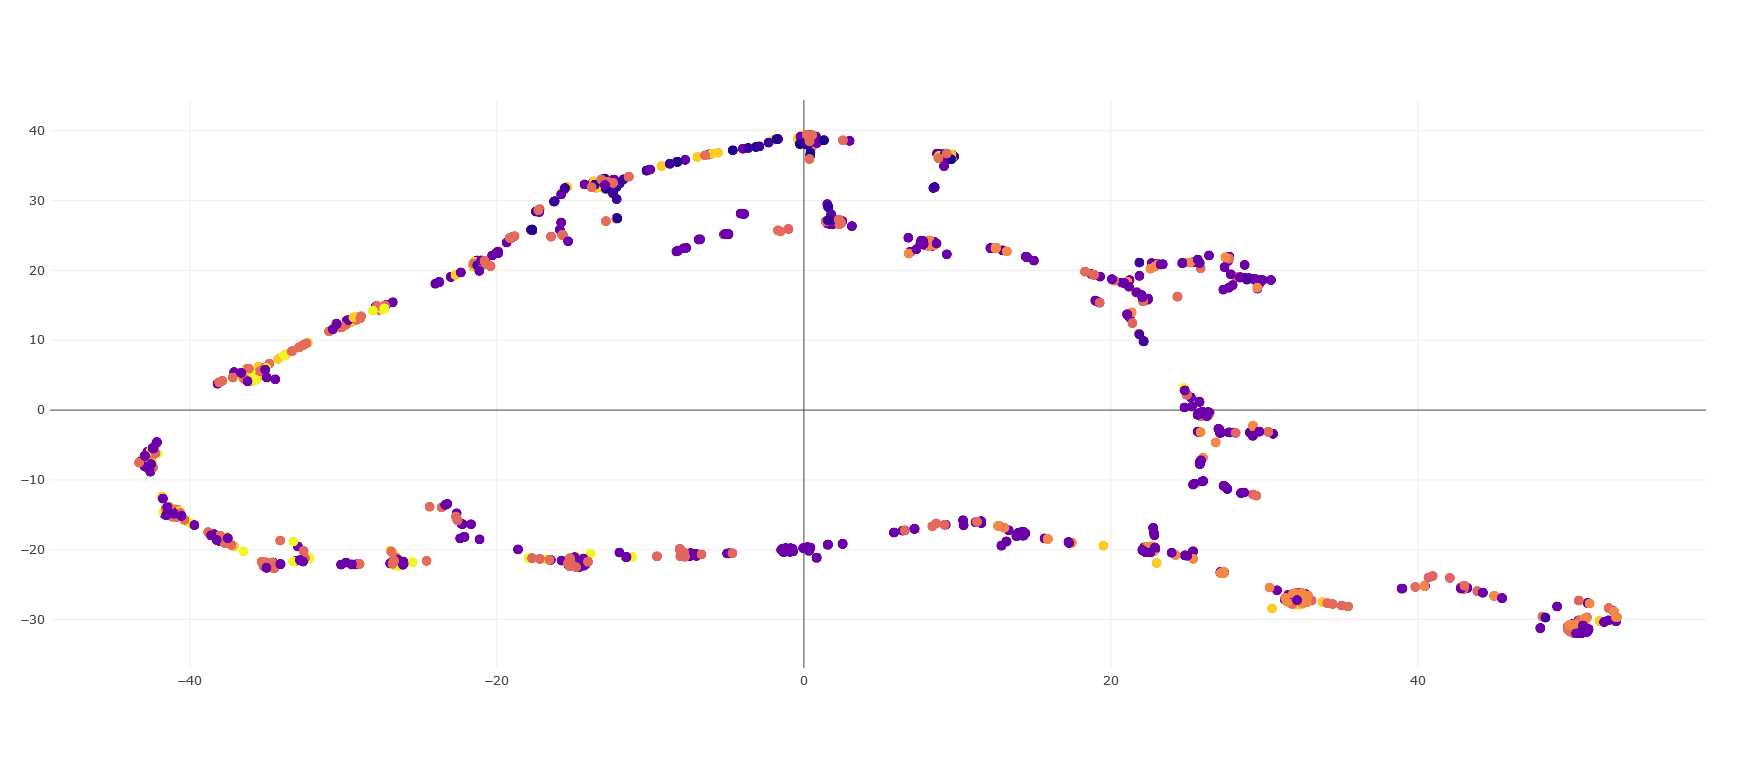

In [46]:
pyo.iplot(make_plot(5))

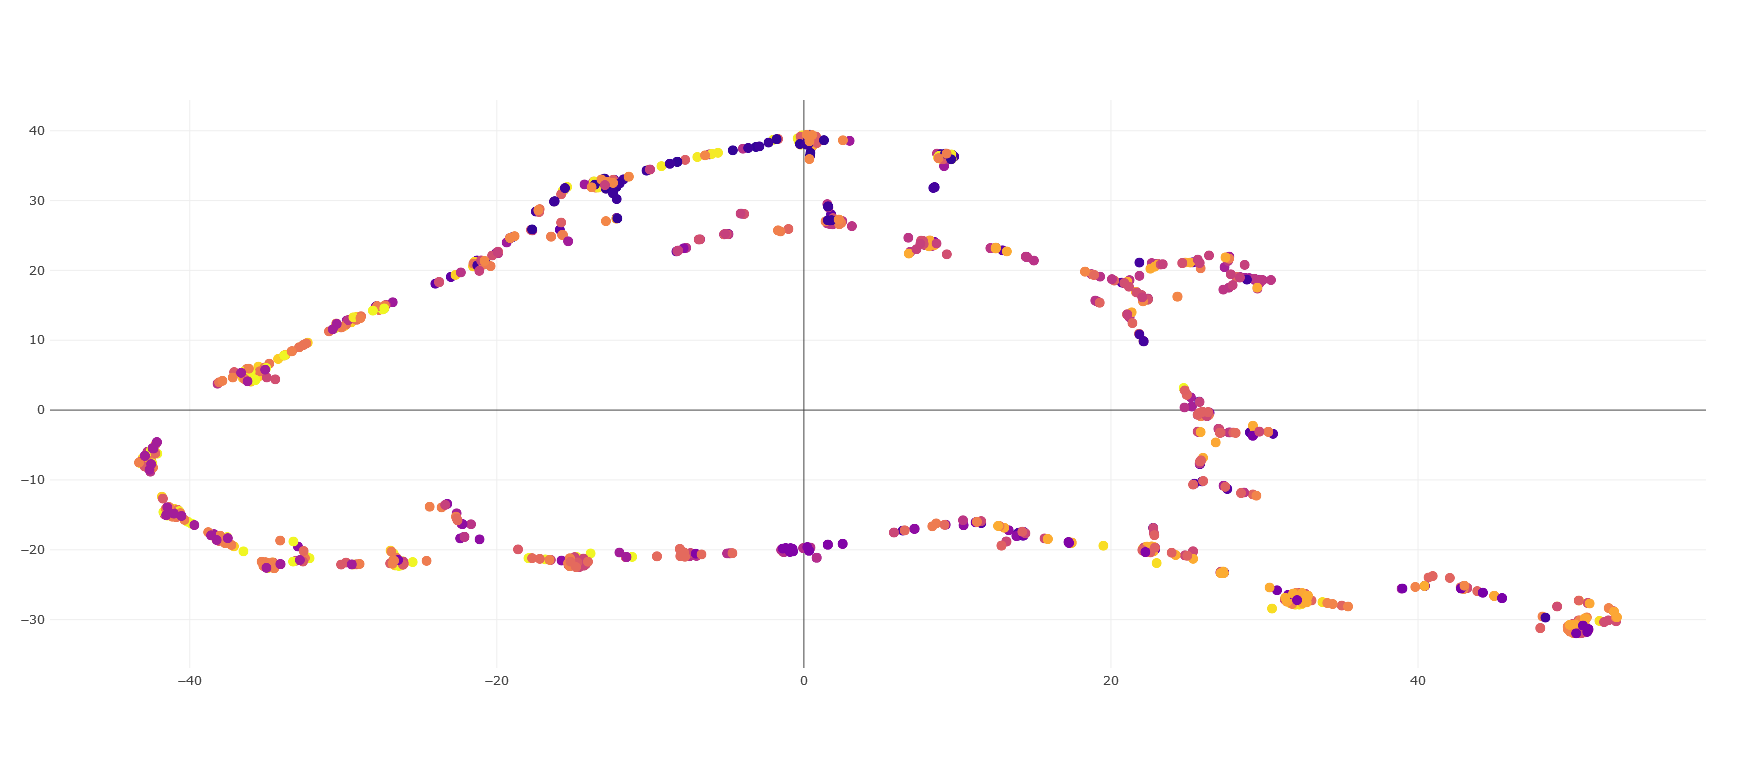

In [47]:
pyo.iplot(make_plot(13))

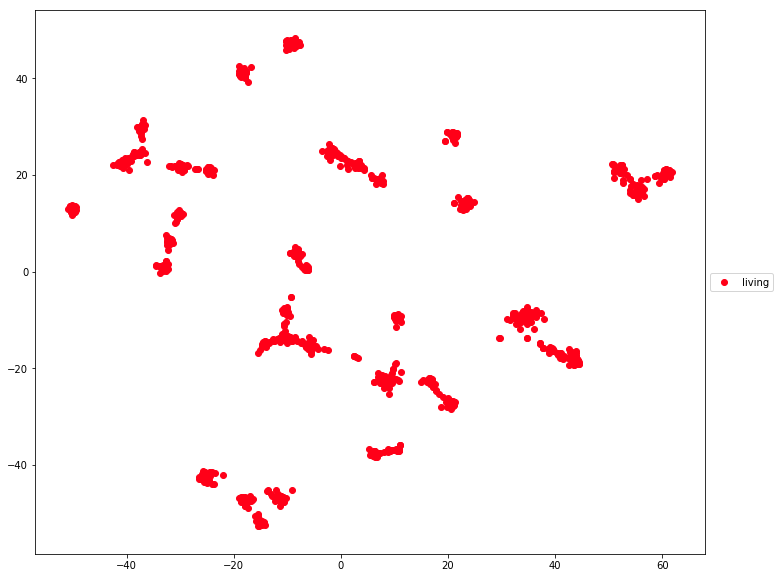

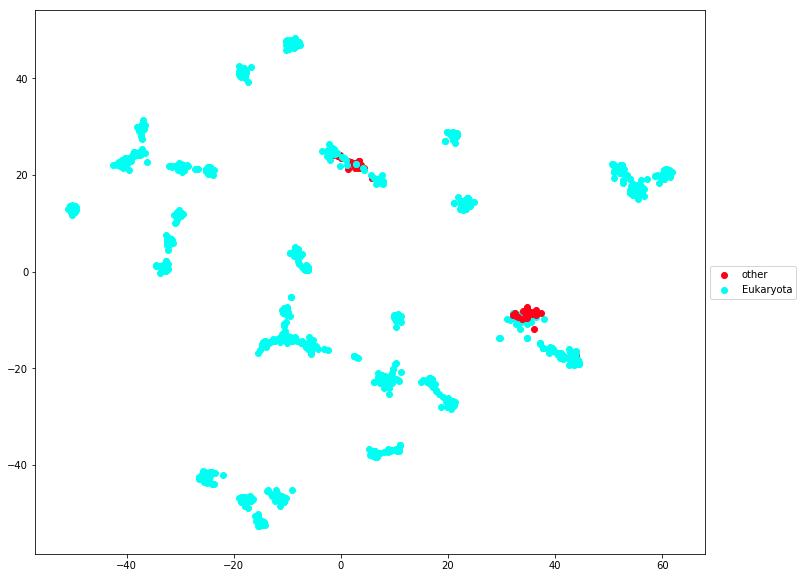

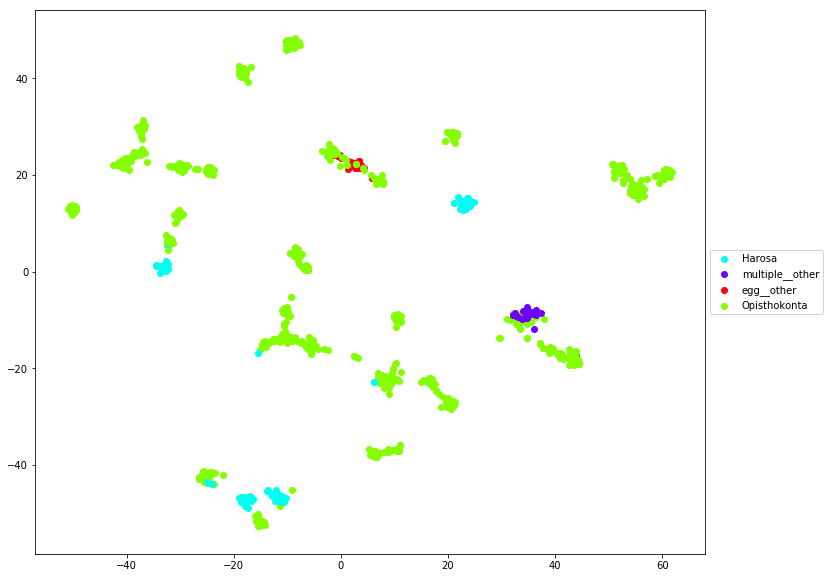

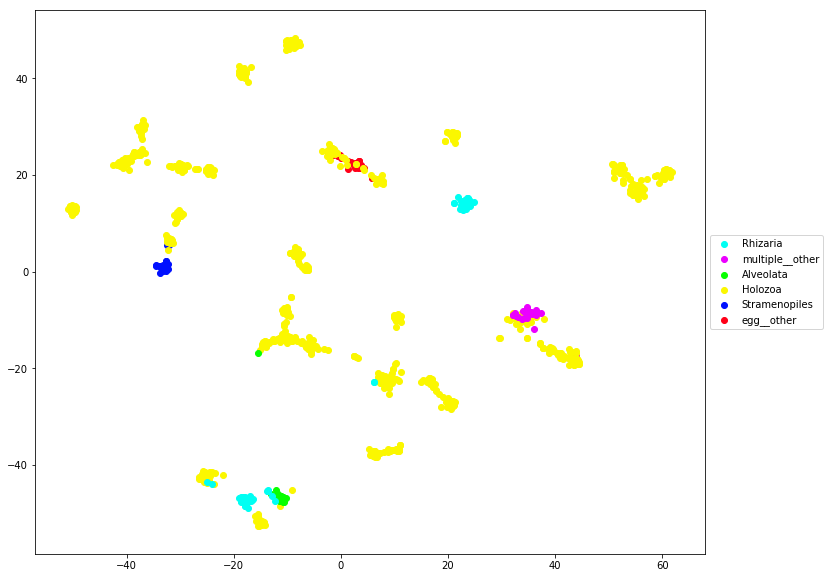

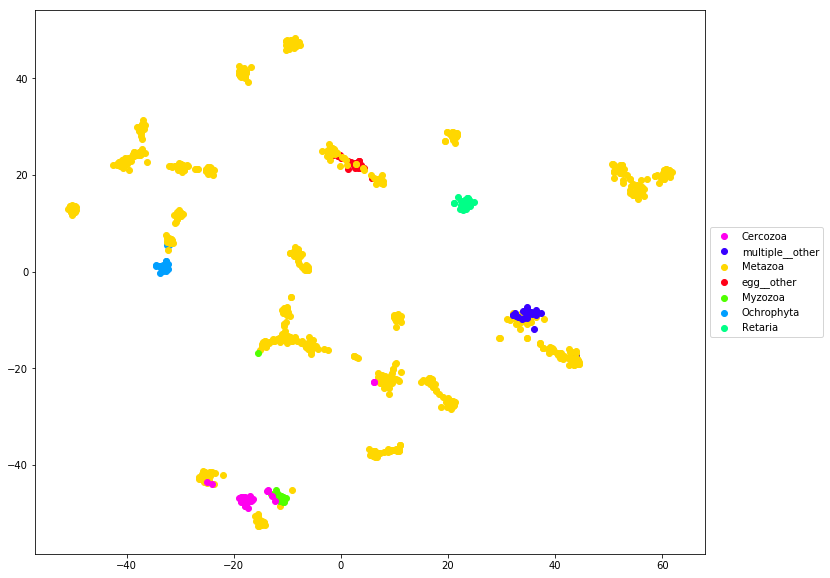

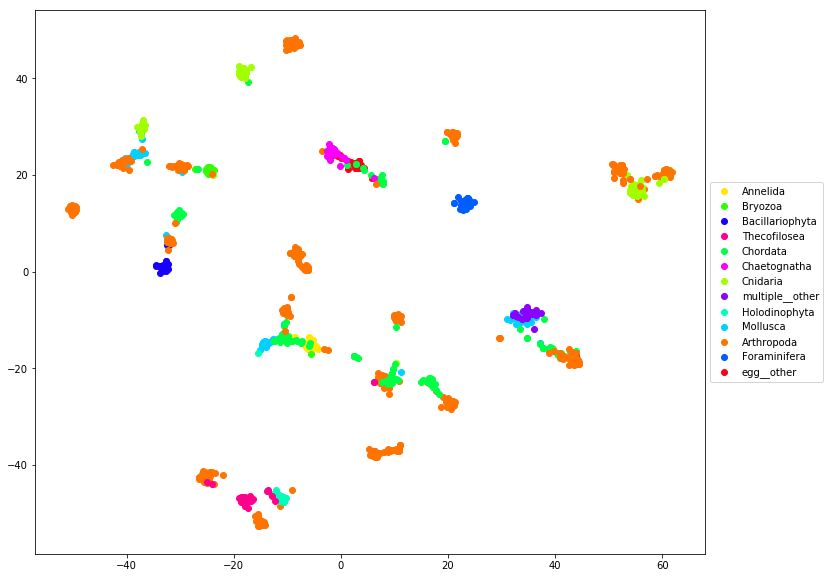

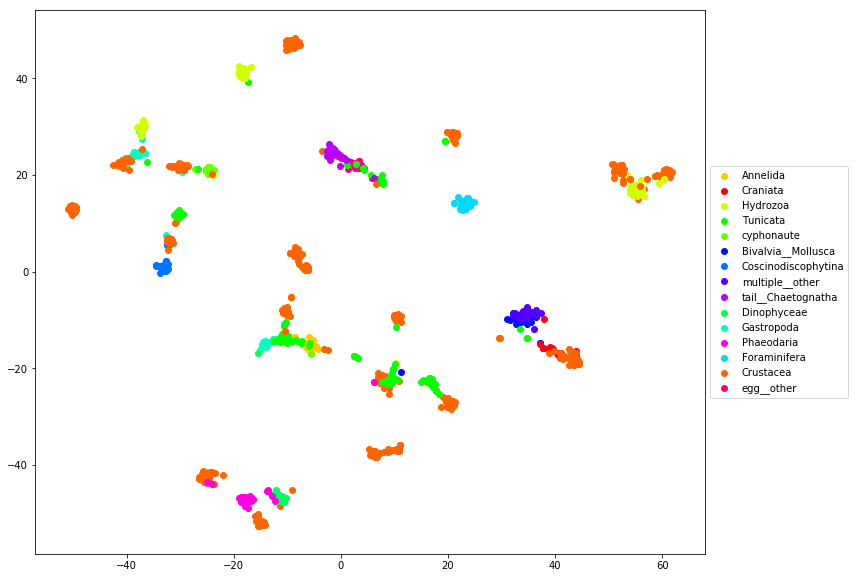

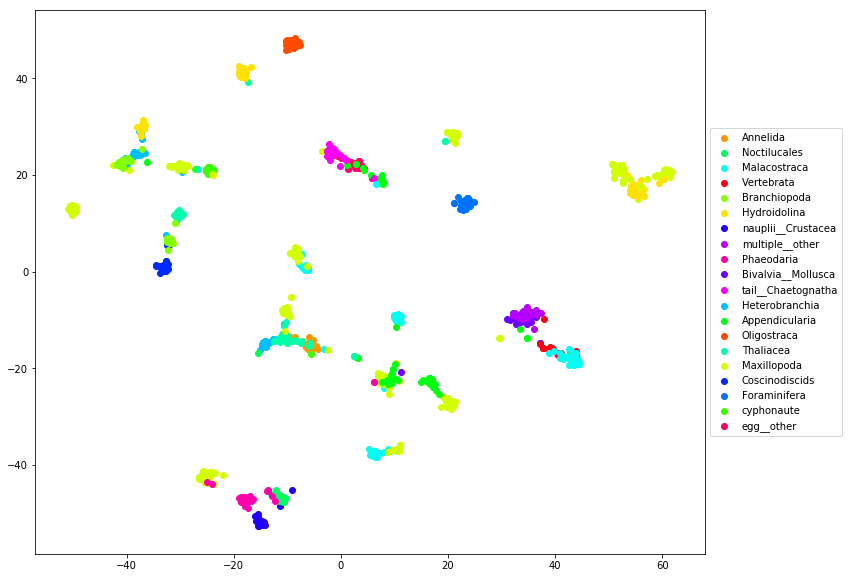

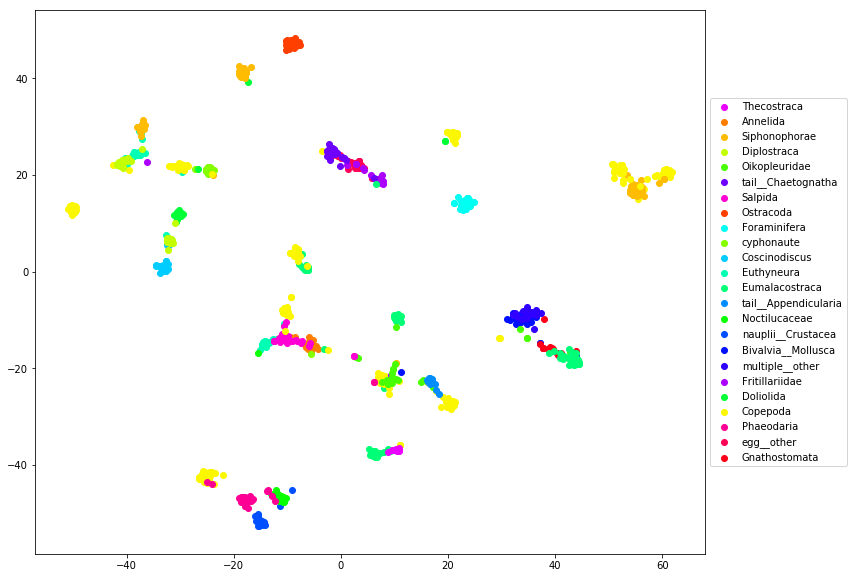

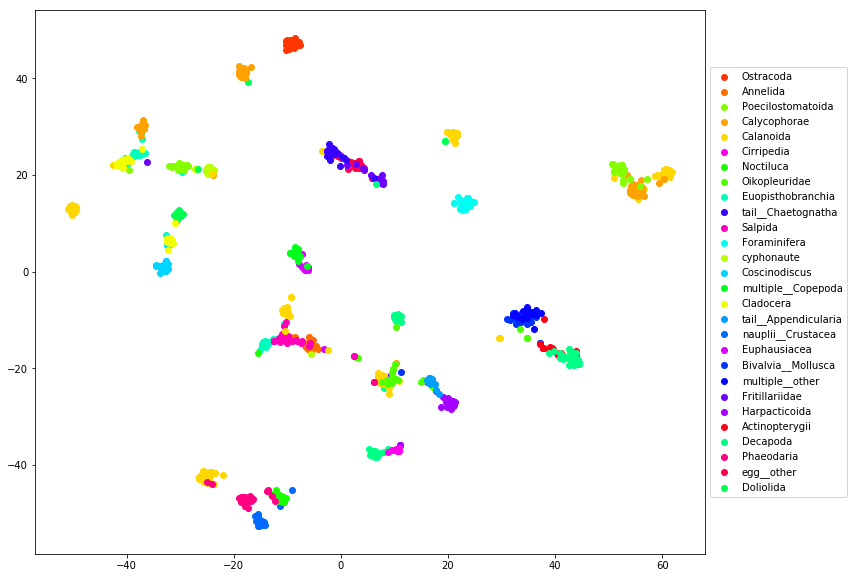

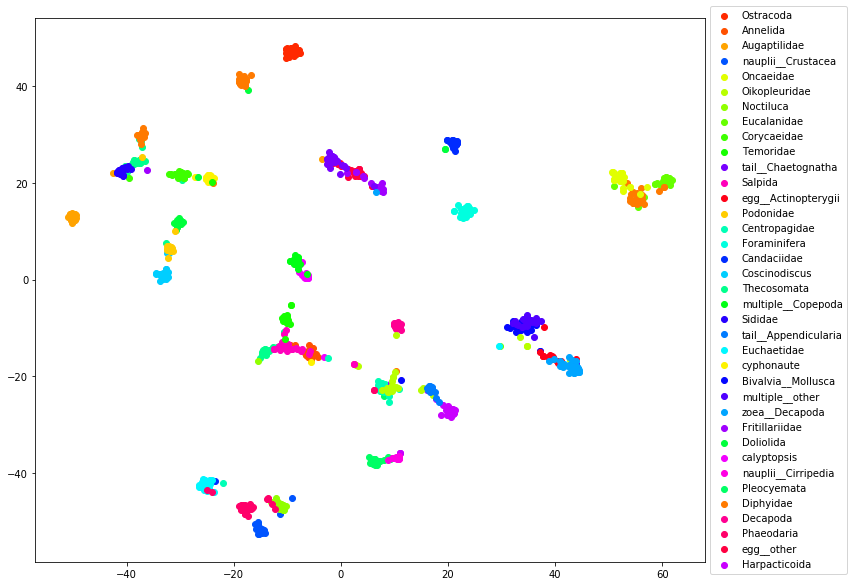

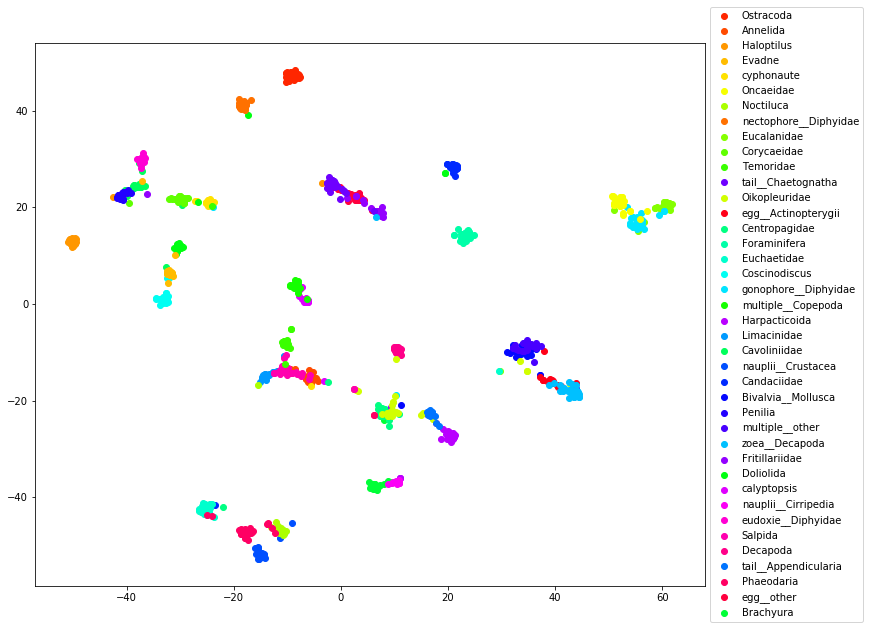

In [4]:
import matplotlib.pyplot as plt
from read_hierarchy import taxonomic_grouping
import numpy as np

#X_2d = np.load('X_2d.npy')
#y = np.load('y.npy')

for j in range(12):
    groups = taxonomic_grouping(j)
    sets = set([j for j, _ in groups.values()])
    cmap = plt.cm.get_cmap('hsv', len(sets)+1)
    fig = plt.figure(figsize=(12, 10))
    ax = plt.subplot(111)

    for i in range(40):
        j, name = groups[i]
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=[cmap(j+1)], label=name)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

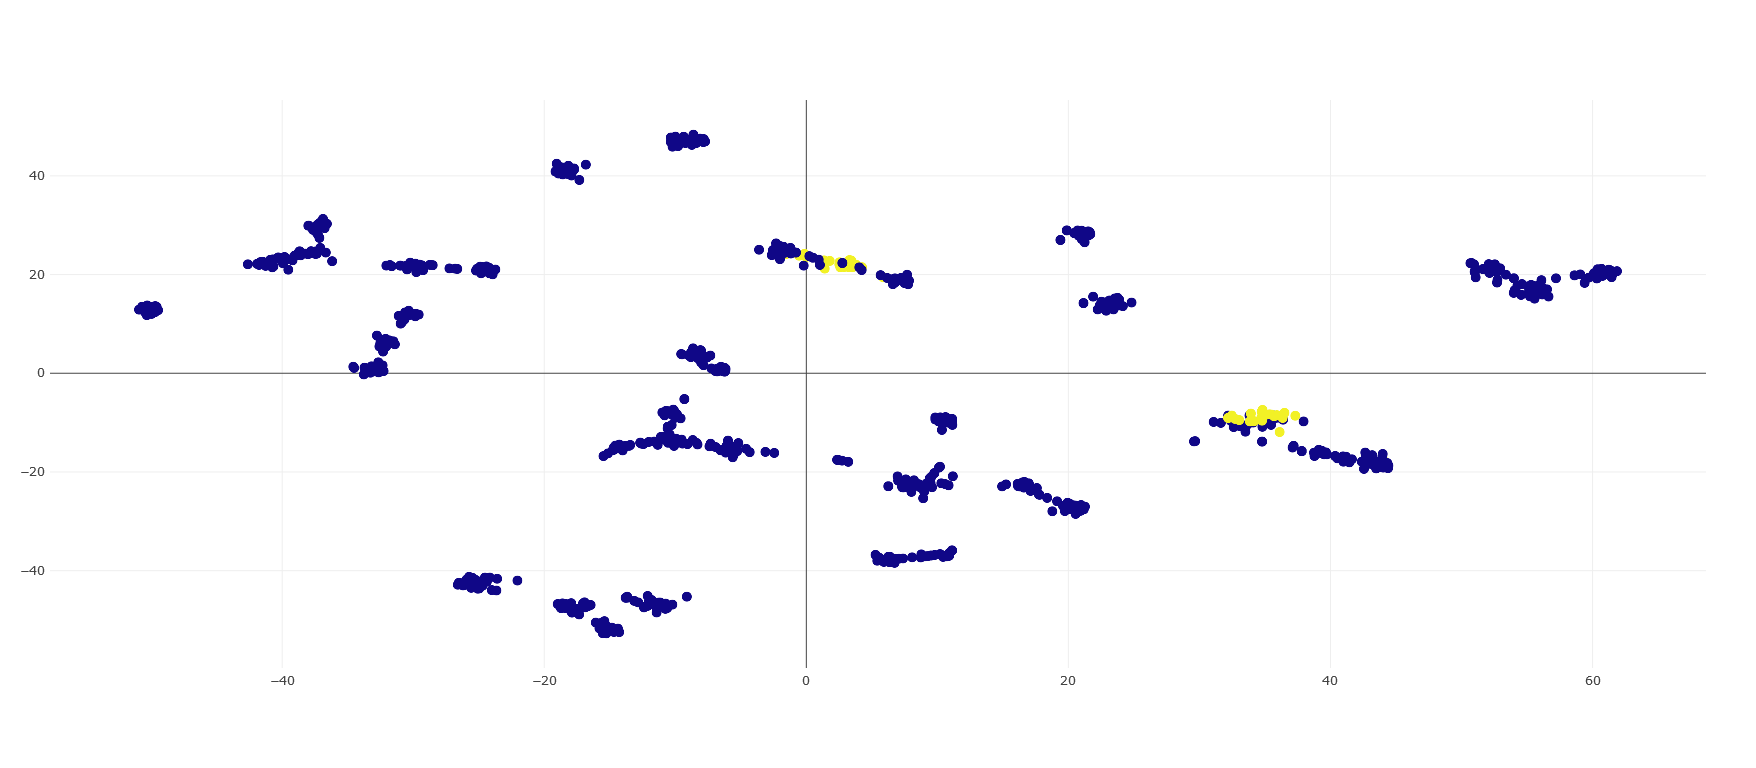

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from read_hierarchy import taxonomic_grouping, taxonomic_path, get_taxonomic_ordering
# Import the necessaries libraries
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()
# Create traces
#X_2d = np.load('X_2d.npy')
#y = np.load('y.npy')
            
def make_plot(j):
    groups = taxonomic_grouping(j)
    sets = set([j for j, _ in groups.values()])
    counter, taxonomic_ordering = get_taxonomic_ordering()
    cmap = plt.cm.get_cmap('plasma', counter)
    
    data = []
    for i in range(40):
        j, name = groups[i]
        color = "rgba({}, {}, {}, {})".format(*[int(col*255) for col in cmap(taxonomic_ordering[name])])
        obj = go.Scattergl(
            x=X_2d[y==i, 0],
            y= X_2d[y==i, 1],
            mode = 'markers',
            marker = dict(
                size=10,
                color = color
            ),
            name = name,
            text = "->".join(taxonomic_path(i)),
            showlegend=False,
            hoverinfo = 'text'
        )
        data.append(obj)
        
    layout = go.Layout(
        autosize=False,
        width=1024,
        height=768,
        hovermode="closest",
        margin=go.layout.Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )
    fig = go.Figure(data=data, layout=layout)
    
    return fig

pyo.iplot(make_plot(1))

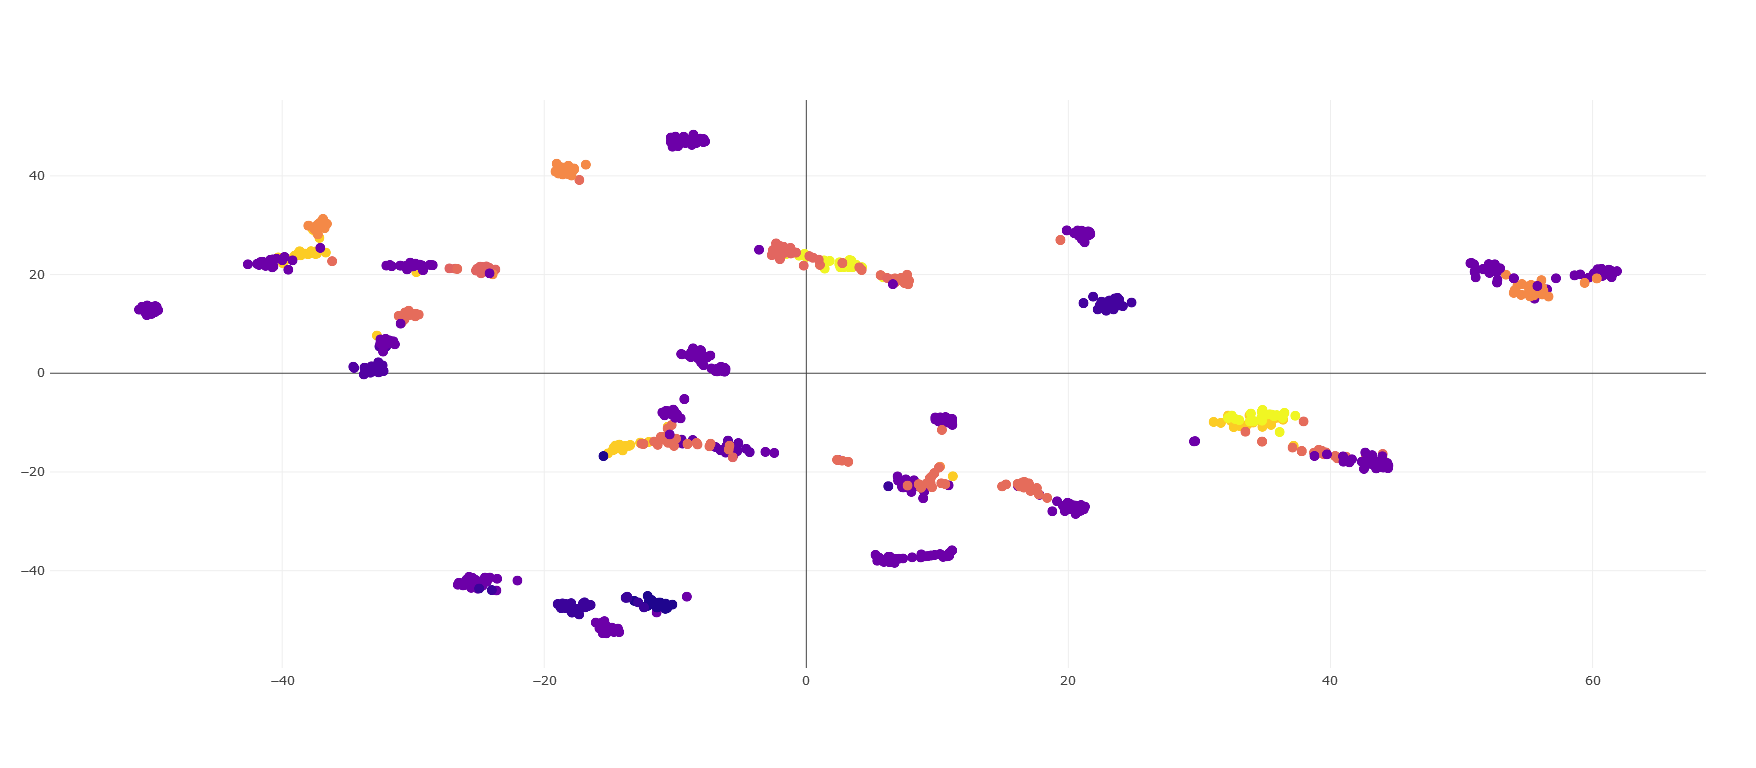

In [34]:
pyo.iplot(make_plot(5))

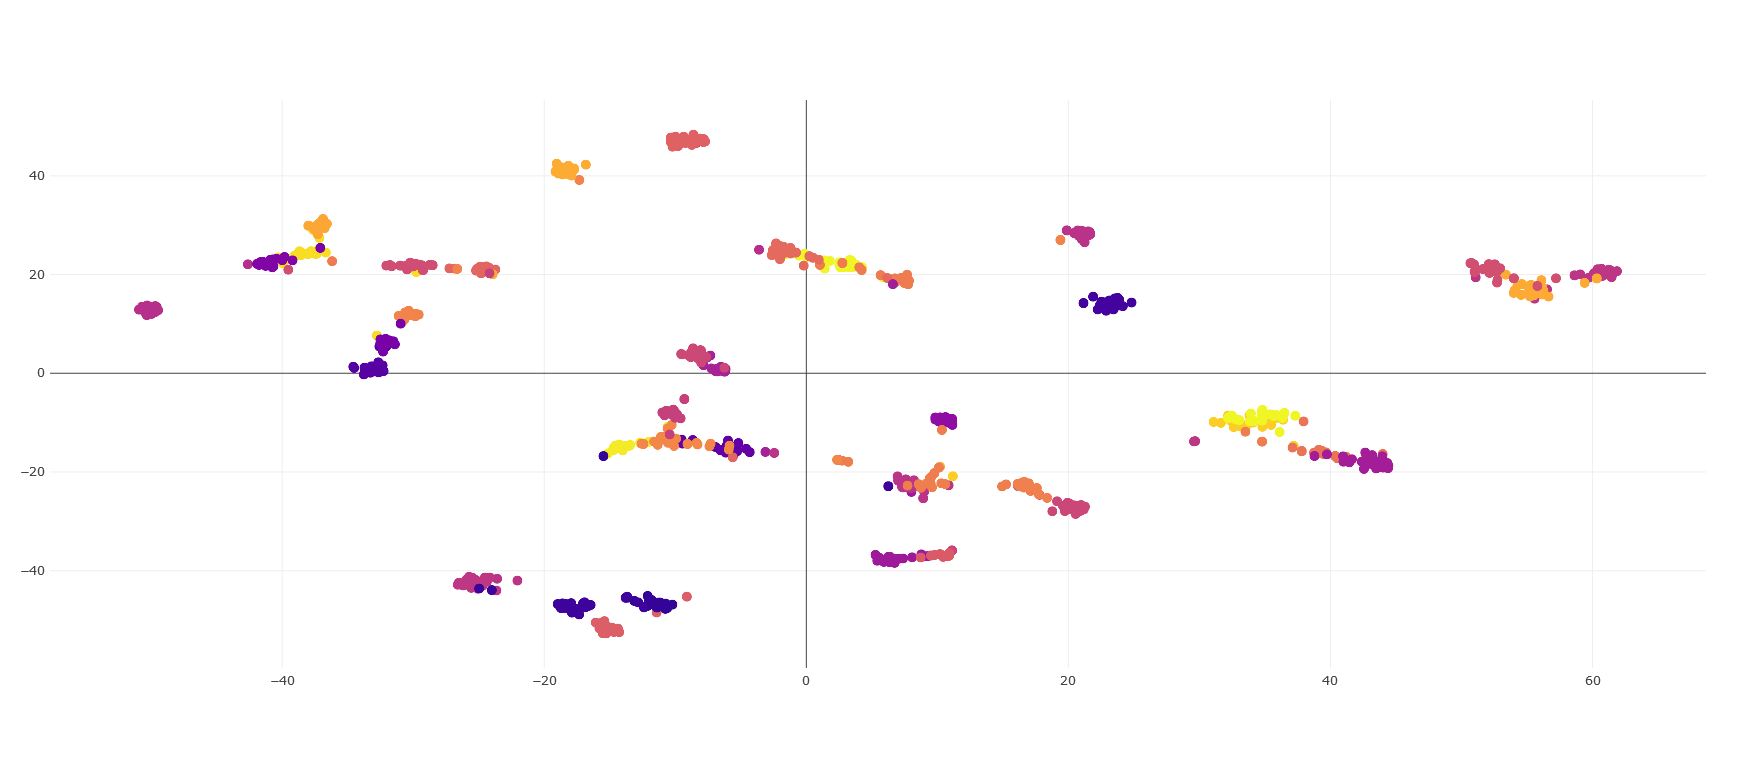

In [35]:
pyo.iplot(make_plot(13))

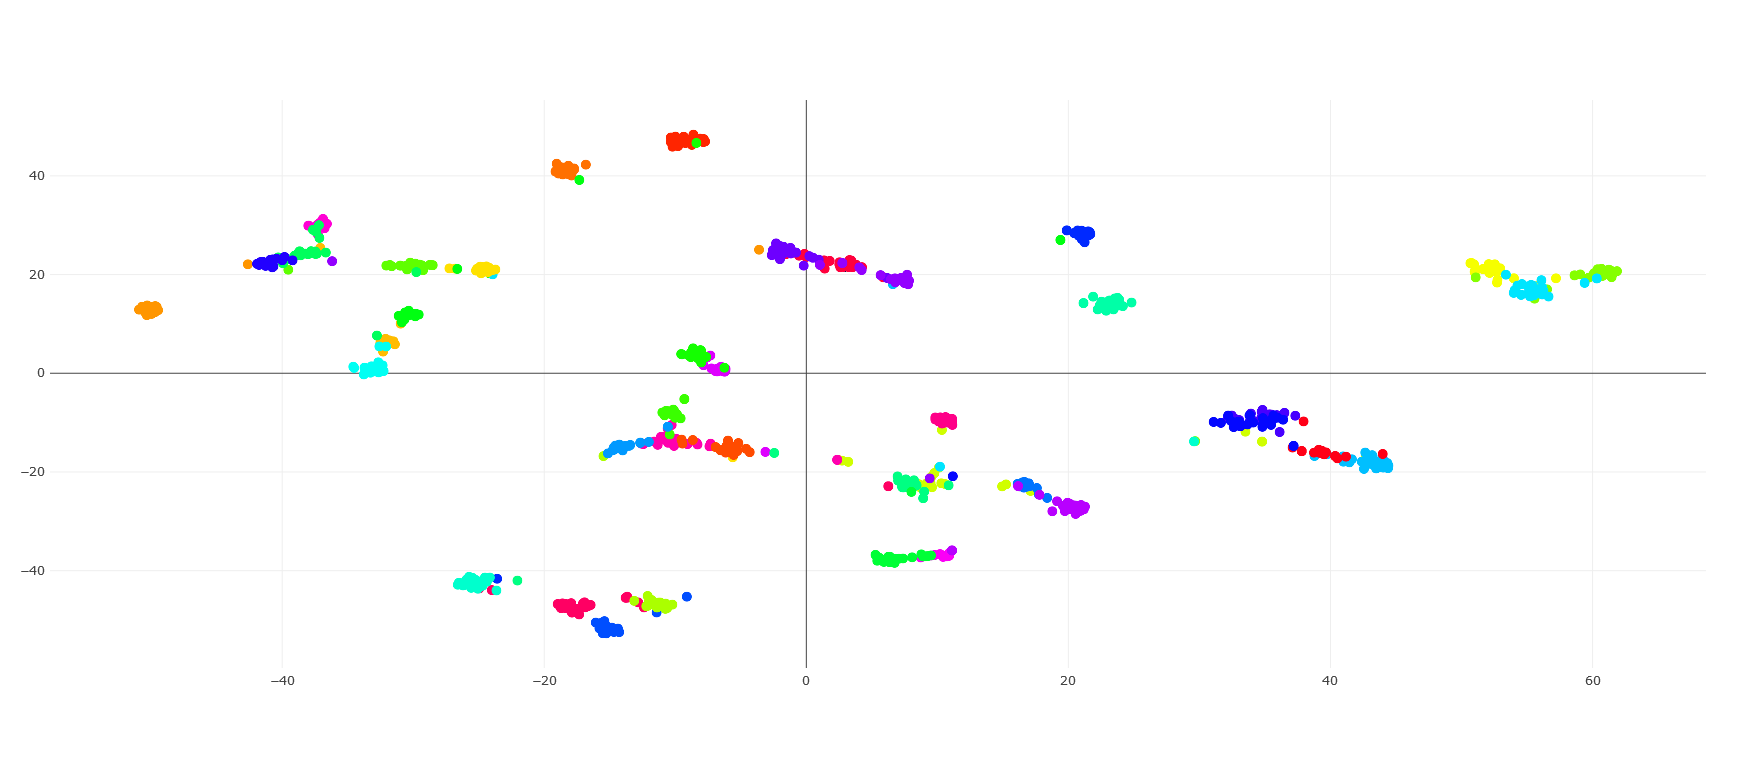

In [6]:
import matplotlib.pyplot as plt
from read_hierarchy import taxonomic_grouping, taxonomic_path, taxonomic_ordering
# Import the necessaries libraries
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()
# Create traces

def myOr(ls_vec):
    if len(ls_vec)==1:
        return ls_vec[0]
    else:
        return ls_vec[0] | myOr(ls_vec[1:])

def make_plot(j):
    groups = taxonomic_grouping(j)
    rev_groups = {}
    for key, val in groups.items():
        if val in rev_groups:
            rev_groups[val].append(key)
        else:
            rev_groups[val] = [key]
    
    sets = set([j for j, _ in groups.values()])
    cmap = plt.cm.get_cmap('hsv', len(sets)+1)
    
    data = []
    for (g, name), vals in rev_groups.items():
        mask = myOr([y==i for i in vals])
        color = "rgba({}, {}, {}, {})".format(*[int(col*255) for col in cmap(g+1)])
        obj = go.Scattergl(
            x=X_2d[mask, 0],
            y= X_2d[mask, 1],
            mode = 'markers',
            marker = dict(
                size=10,
                color = color
            ),
            name = name,
            text = name,
            showleg
        )
        
        data.append(obj)
        
    layout = go.Layout(
        autosize=False,
        width=1024,
        height=768,
        margin=go.layout.Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )
    fig = go.Figure(data=data, layout=layout)
    pyo.iplot(fig)

make_plot(13)

In [14]:
sets, groups = taxonomic_grouping(3)

In [15]:
groups.items()

dict_items([(0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 2), (9, 3), (10, 3), (11, 3), (12, 3), (13, 4), (14, 3), (15, 3), (16, 3), (17, 3), (18, 1), (19, 3), (20, 3), (21, 3), (22, 3), (23, 3), (24, 3), (25, 5), (26, 3), (27, 3), (28, 3), (29, 0), (30, 3), (31, 3), (32, 3), (33, 3), (34, 1), (35, 3), (36, 3), (37, 3), (38, 3), (39, 3)])

In [11]:
del bitvector_model

In [12]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [ ]:
quickref()

In [26]:
[int(col*255) for col in cmap(j+1)]

[208, 255, 0, 255]

In [16]:
"rgba({}, {}, {}, {})".format(*[int(col*255) for col in cmap(j+1)])

'rgba(0, 255, 17, 255)'

In [20]:
groups = taxonomic_grouping(j)
rev_groups = {}
for key, val in groups.items():
    if val in rev_groups:
        rev_groups[val].append(key)
    else:
        rev_groups[val] = [key]

In [21]:
rev_groups

{(0, 'gonophore__Diphyidae'): [20],
 (1, 'Limacinidae'): [23],
 (2, 'tail__Chaetognatha'): [37],
 (3, 'Centropagidae'): [6],
 (4, 'Oncaeidae'): [31],
 (5, 'eudoxie__Diphyidae'): [16],
 (6, 'Decapoda'): [10],
 (7, 'nauplii__Cirripedia'): [26],
 (8, 'egg__other'): [13],
 (9, 'Evadne'): [17],
 (10, 'Fritillariidae'): [19],
 (11, 'Candaciidae'): [4],
 (12, 'Haloptilus'): [21],
 (13, 'zoea__Decapoda'): [39],
 (14, 'egg__Actinopterygii'): [12],
 (15, 'Penilia'): [33],
 (16, 'Temoridae'): [38],
 (17, 'Coscinodiscus'): [8],
 (18, 'Bivalvia__Mollusca'): [1],
 (19, 'Noctiluca'): [29],
 (20, 'Salpida'): [35],
 (21, 'Ostracoda'): [32],
 (22, 'Brachyura'): [2],
 (23, 'Harpacticoida'): [22],
 (24, 'nauplii__Crustacea'): [27],
 (25, 'nectophore__Diphyidae'): [28],
 (26, 'Corycaeidae'): [7],
 (27, 'multiple__Copepoda'): [24],
 (28, 'calyptopsis'): [3],
 (29, 'Euchaetidae'): [15],
 (30, 'Annelida'): [0],
 (31, 'cyphonaute'): [9],
 (32, 'multiple__other'): [25],
 (33, 'Cavoliniidae'): [5],
 (34, 'tail__

'living->Eukaryota->Opisthokonta->Holozoa->Metazoa->Annelida'